<a href="https://colab.research.google.com/github/momenashra/Recommandation-systems/blob/main/Neural_collaborative_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 1: Introduction to Recommendation Engines

## Basic imports

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import models , layers ,optimizers ,losses ,regularizers ,metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Collaborative filtering



Extract the user/movie rating matrix from MovieLens dataset using pandas, for the top 15 movies and users.

## Preparation

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2025-02-13 13:32:36--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.30MB/s    in 0.2s    

2025-02-13 13:32:37 (4.30 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

<ipython-input-8-ffa4c652a98f>:11: FutureWarning: The provided callable <function sum at 0x7da9c85cca40> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


Encode the user id, and movie id categorical variables, using sklean LabelEncoder to be used with the Embedding layer.

In [10]:
from sklearn.preprocessing import LabelEncoder
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

Build the collaborative filtering model, using keras Embedding and Dot layers

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding_LUT        │ (None, 1, 50)          │         30,500 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding_LUT       │ (None, 1, 50)          │        486,200 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 50)             │              0 │ user_embedding_LUT[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 50)             │              0 │ movie_embedding_LUT[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_measure (Dot)  │ (None, 1)              │              0 │ reshape_2[0][0],       │
│                           │                        │                │ reshape_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

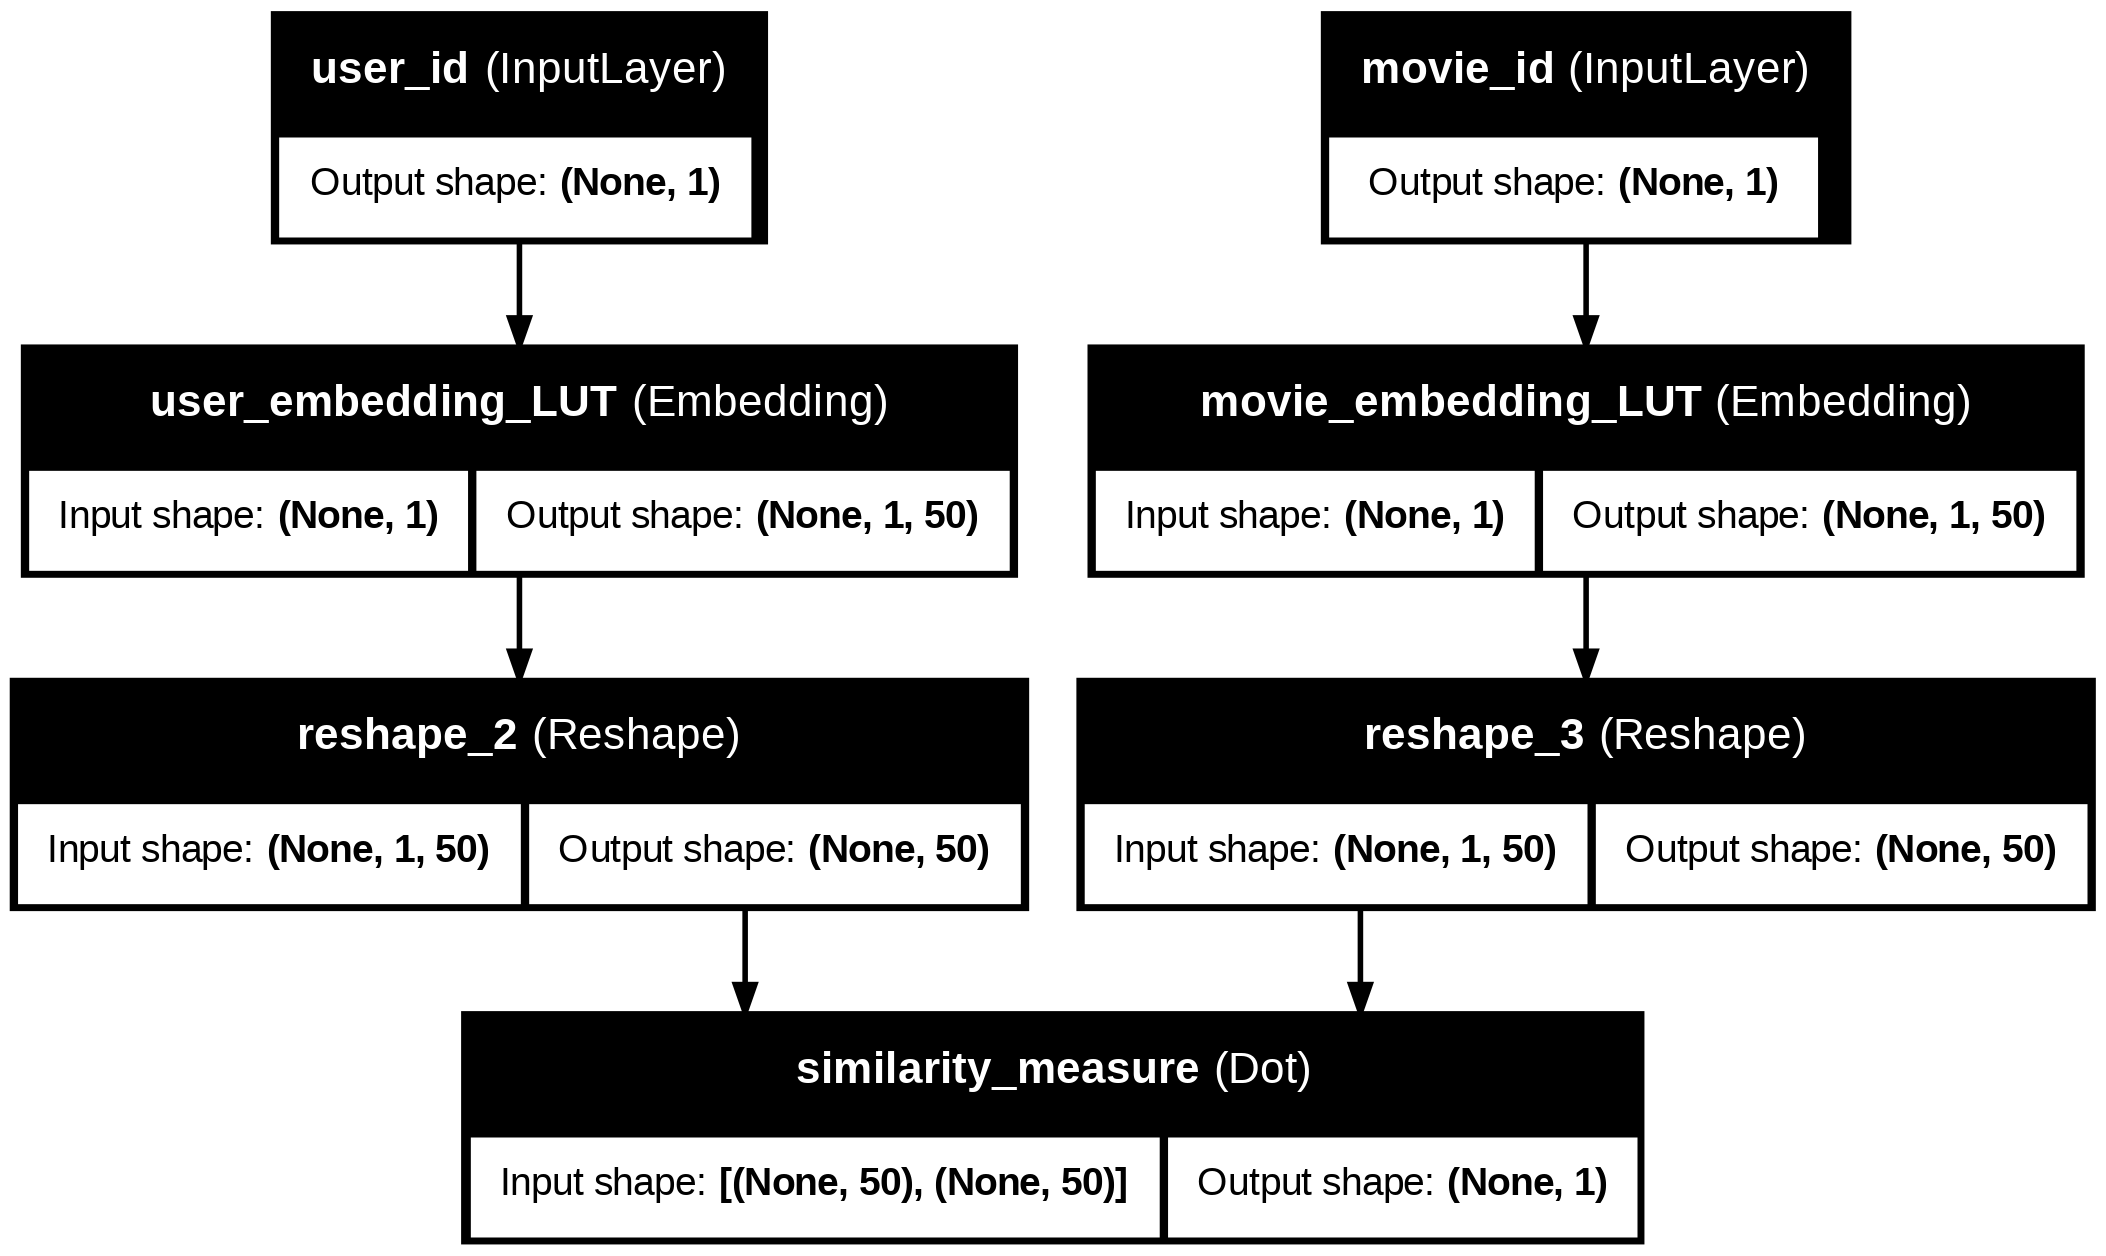

In [13]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,), name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1, name='similarity_measure')([user_emb, movie_emb])


# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())


# Show model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Extract the train and test data for MovieLens

In [14]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90752, 2) (90752,)
(10084, 2) (10084,)


In [15]:
# Compile the model
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 12.3031 - root_mean_squared_error: 3.5026 - val_loss: 3.2820 - val_root_mean_squared_error: 1.8102
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 2.3910 - root_mean_squared_error: 1.5417 - val_loss: 1.6339 - val_root_mean_squared_error: 1.2744
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 1.1811 - root_mean_squared_error: 1.0818 - val_loss: 1.3540 - val_root_mean_squared_error: 1.1583
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.8735 - root_mean_squared_error: 0.9277 - val_loss: 1.2728 - val_root_mean_squared_error: 1.1220
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.7344 - root_mean_squared_error: 0.8484 - val_loss: 1.2278 - val_root_mean_squared_error: 1.1011


In [27]:
X_test

array([[ 431, 7316],
       [ 287,  412],
       [ 598, 3217],
       ...,
       [ 115, 5721],
       [ 110, 3650],
       [ 478,  309]])

In [41]:
predictions = model.predict([X_test[:, 0], X_test[:, 1]])  # Extract users and items separately
print("Predicted ratings:", predictions)

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted ratings: [[2.99263  ]
 [3.2569442]
 [2.5816438]
 ...
 [3.1346612]
 [2.3349502]
 [3.5094962]]


In [42]:
mae=np.mean(np.abs((predictions-y_test)))
print(mae)

0.99495095


In [29]:
for i in range(5):
    print(f"User {X_test[i, 0]} - Item {X_test[i, 1]}: Predicted Rating = {predictions[i][0]}")

User 431 - Item 7316: Predicted Rating = 2.925797462463379
User 287 - Item 412: Predicted Rating = 3.4352529048919678
User 598 - Item 3217: Predicted Rating = 2.9034647941589355
User 41 - Item 2248: Predicted Rating = 3.6754372119903564
User 74 - Item 1210: Predicted Rating = 3.379409074783325


# Improving the recommendation engine and analysis

## Scaling the model output with sigmoid

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │         30,500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 50)          │        486,200 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 50)             │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 50)             │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_1 (Dot)               │ (None, 1)              │              0 │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1)              │              0 │ dot_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ activation_1[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

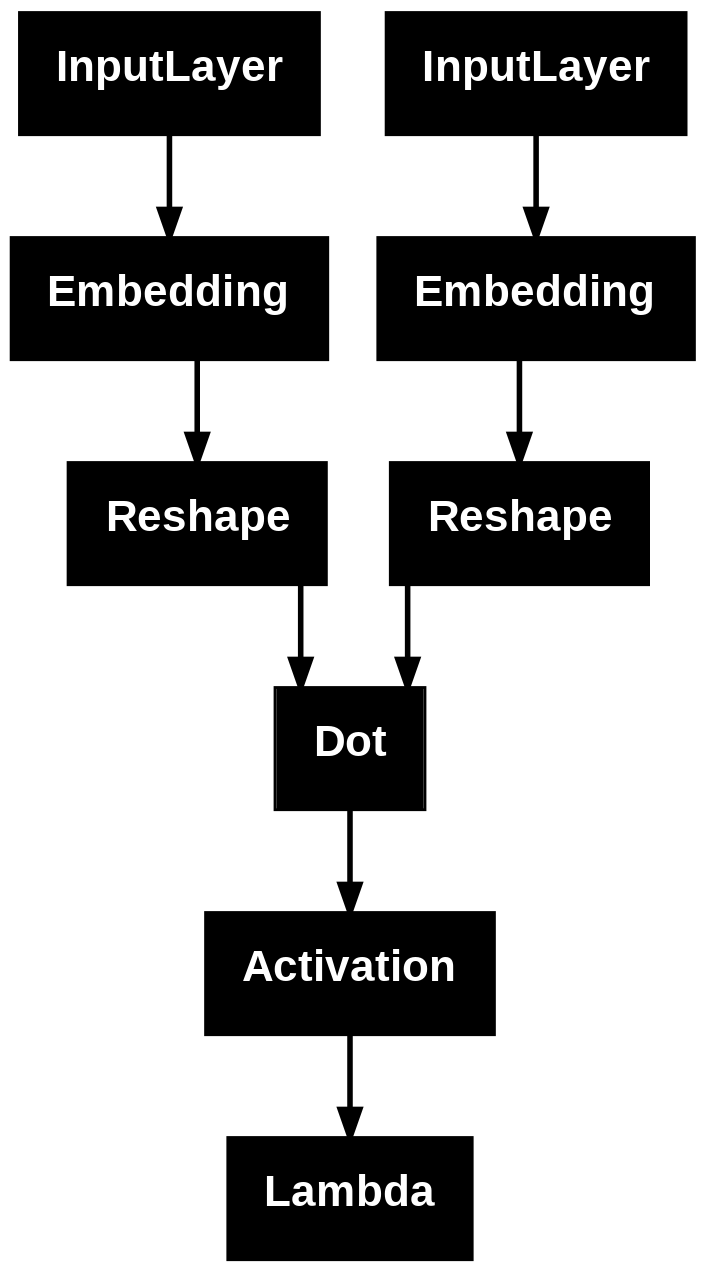

In [36]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1)([user_emb, movie_emb])
rating = layers.Activation('sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Show model summary
model.summary()
plot_model(model)

In [38]:
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())

In [39]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 1.5733 - root_mean_squared_error: 1.2535 - val_loss: 0.9287 - val_root_mean_squared_error: 0.9628
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.7975 - root_mean_squared_error: 0.8917 - val_loss: 0.8052 - val_root_mean_squared_error: 0.8954
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.6154 - root_mean_squared_error: 0.7820 - val_loss: 0.7750 - val_root_mean_squared_error: 0.8775
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.4849 - root_mean_squared_error: 0.6925 - val_loss: 0.7666 - val_root_mean_squared_error: 0.8719
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.3939 - root_mean_squared_error: 0.6223 - val_loss: 0.7738 - val_root_mean_squared_error: 0.8754


## Adding user and movie biases

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_id (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 50)          │         30,500 │ user_id[0][0]          │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 50)          │        486,200 │ movie_id[0][0]         │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_12 (Reshape)      │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 50)             │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_bias (Embedding)     │ (None, 1, 1)           │            610 │ user_id[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_bias (Embedding)    │ (None, 1, 1)           │          9,724 │ movie_id[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ similarity_measure (Dot)  │ (None, 1)              │              0 │ reshape_12[0][0],      │
│                           │                        │                │ reshape_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_13 (Reshape)      │ (None, 1)              │              0 │ user_bias[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_15 (Reshape)      │ (None, 1)              │              0 │ movie_bias[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1)              │              0 │ similarity_measure[0]… │
│                           │                        │                │ reshape_13[0][0],      │
│                           │                        │                │ reshape_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_scaling            │ (None, 1)              │              0 │ add_1[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ rating_scaling[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 527,034 (2.01 MB)

 Trainable params: 527,034 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


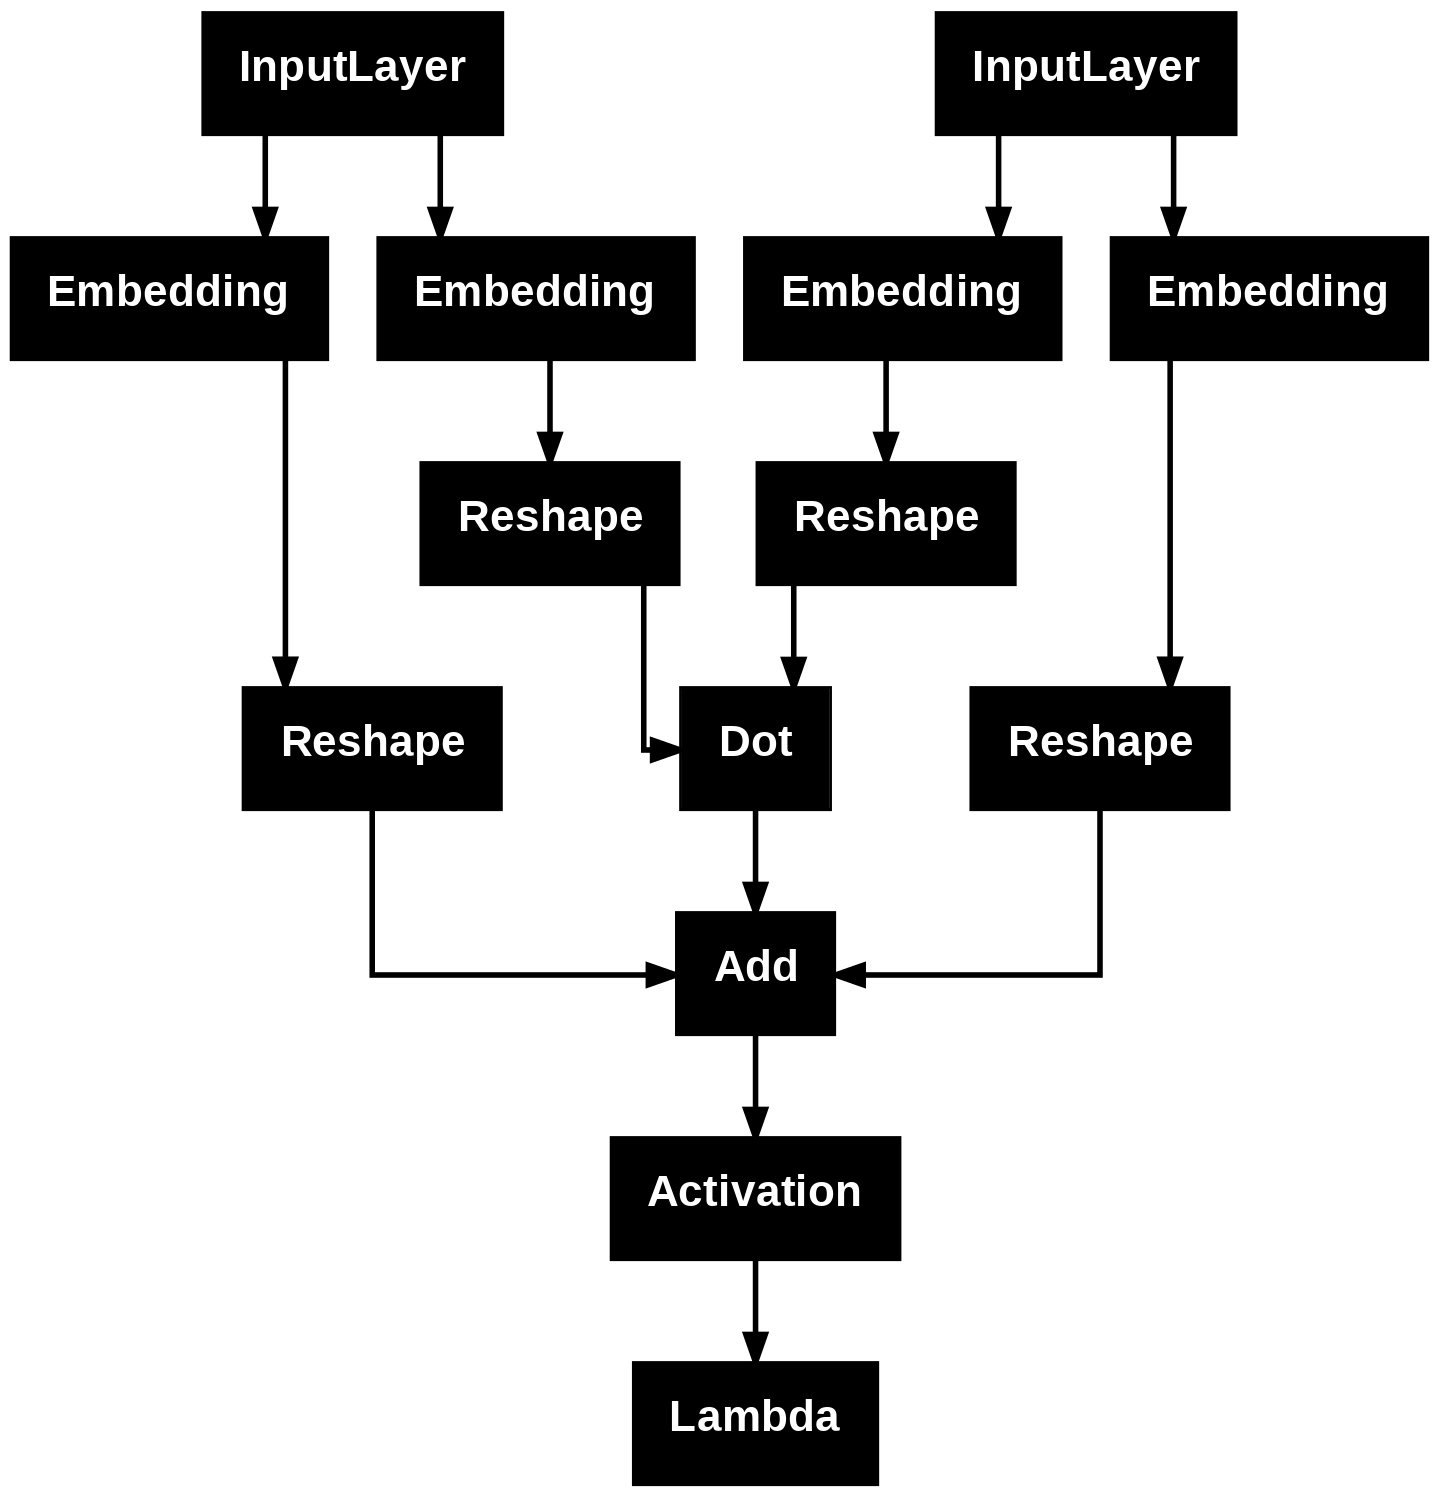

In [45]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,),name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='user_embedding')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6),name='user_bias')(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,),name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6),name='movie_embedding')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6),name='movie_bias')(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Dot(axes=1,name='similarity_measure')([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Activation('sigmoid',name='rating_scaling')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [46]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 1.4169 - root_mean_squared_error: 1.1890 - val_loss: 0.8562 - val_root_mean_squared_error: 0.9246
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.7388 - root_mean_squared_error: 0.8584 - val_loss: 0.7515 - val_root_mean_squared_error: 0.8653
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.5594 - root_mean_squared_error: 0.7457 - val_loss: 0.7288 - val_root_mean_squared_error: 0.8511
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.4212 - root_mean_squared_error: 0.6453 - val_loss: 0.7311 - val_root_mean_squared_error: 0.8517
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.3214 - root_mean_squared_error: 0.5615 - val_loss: 0.7446 - val_root_mean_squared_error: 0.8588


## Going deeper
- use Dense layers to build deeper models.


## Answer

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 1, 50)          │         30,500 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 1, 50)          │        486,200 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_20 (Reshape)      │ (None, 50)             │              0 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_22 (Reshape)      │ (None, 50)             │              0 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 1, 1)           │            610 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 1, 1)           │          9,724 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100)            │              0 │ reshape_20[0][0],      │
│ (Concatenate)             │                        │                │ reshape_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_21 (Reshape)      │ (None, 1)              │              0 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_23 (Reshape)      │ (None, 1)              │              0 │ embedding_11[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 100)            │              0 │ concatenate_1[0][0],   │
│                           │                        │                │ reshape_21[0][0],      │
│                           │                        │                │ reshape_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10)             │          1,010 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             11 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 528,055 (2.01 MB)

 Trainable params: 528,055 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


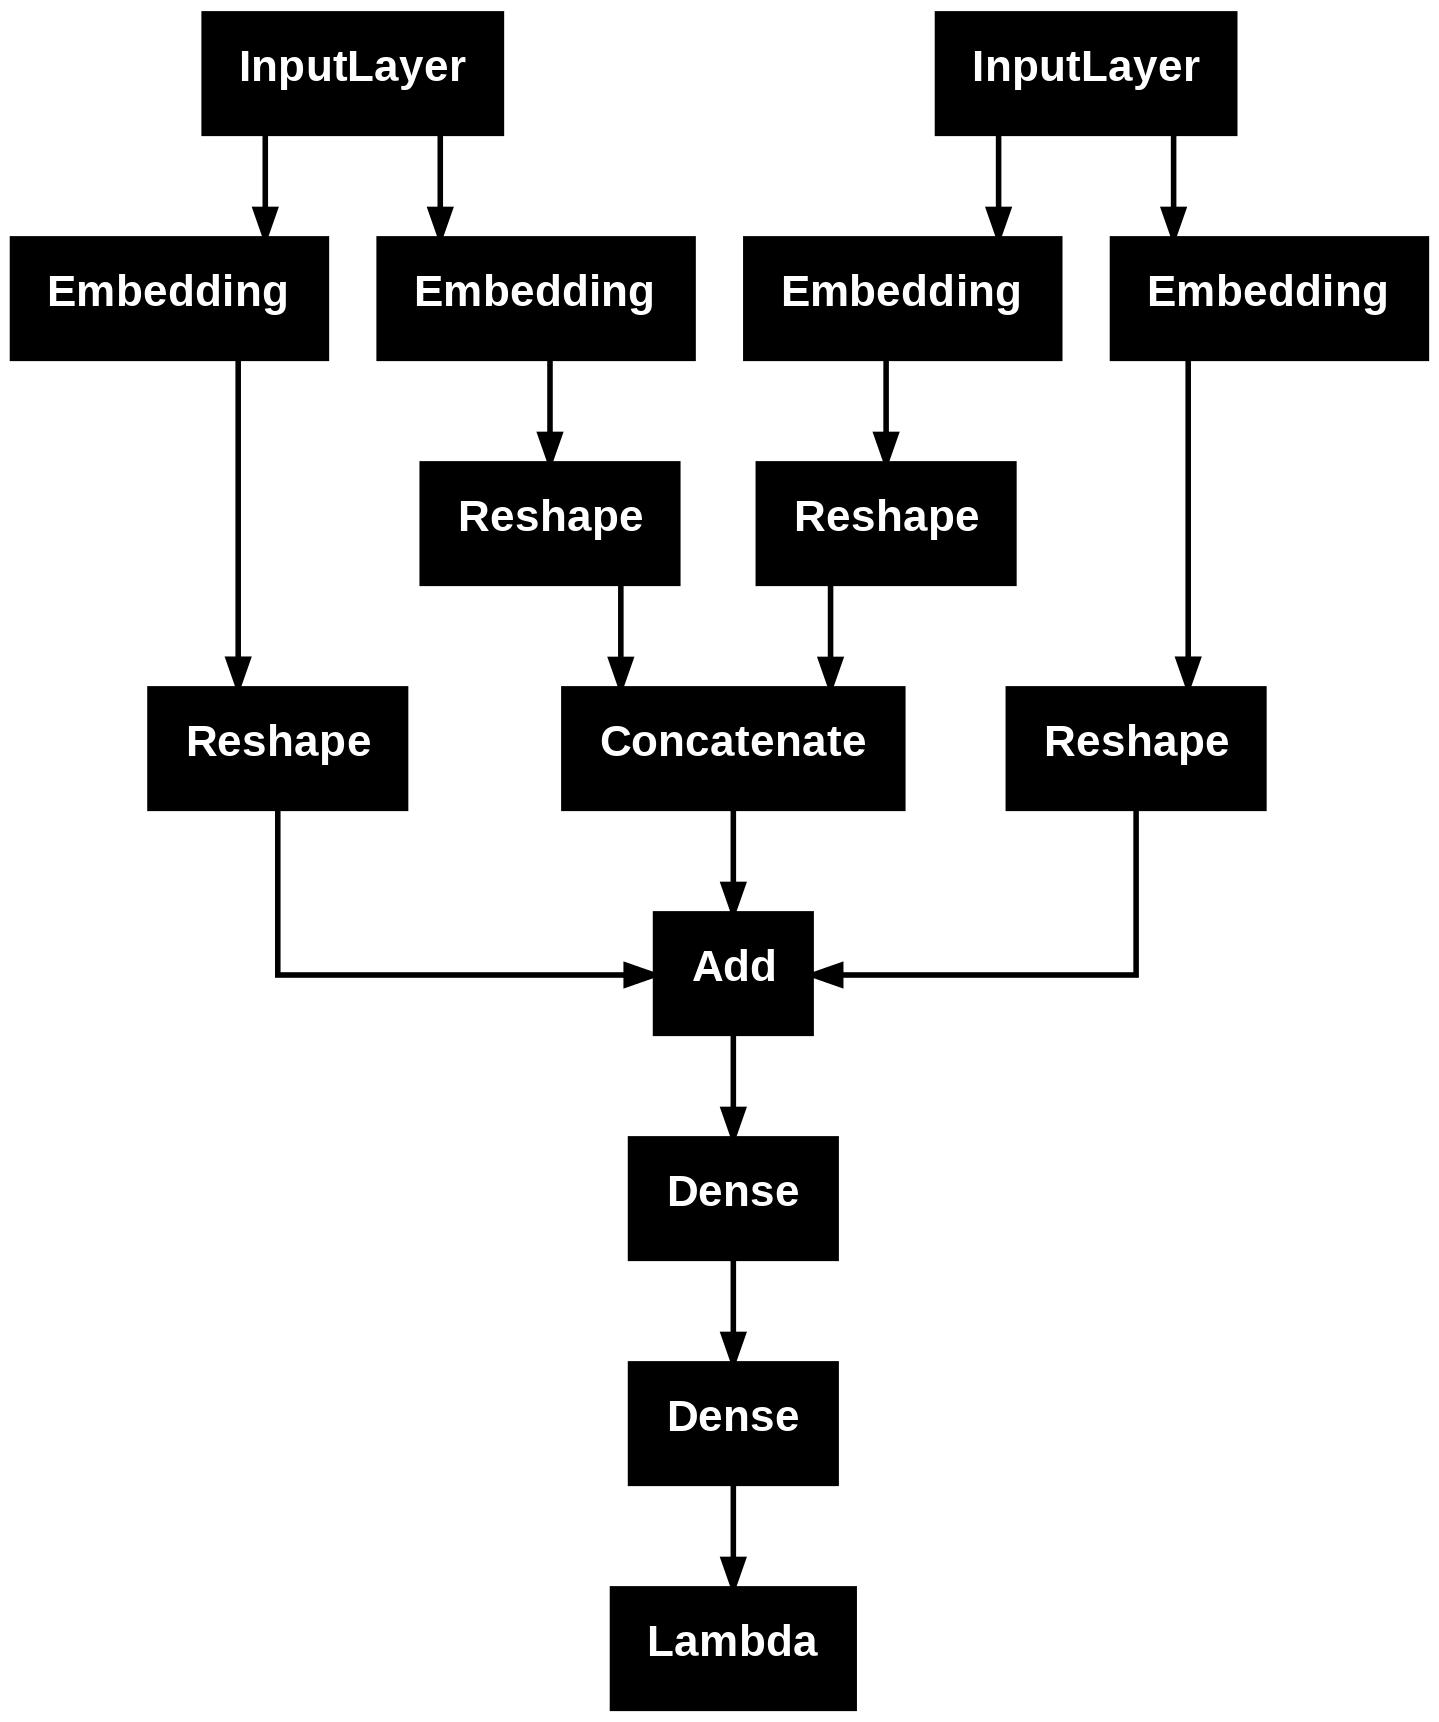

In [48]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz)(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1)(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz)(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1)(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())


# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [49]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.9703 - root_mean_squared_error: 0.9821 - val_loss: 0.7903 - val_root_mean_squared_error: 0.8890
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.6756 - root_mean_squared_error: 0.8219 - val_loss: 0.7673 - val_root_mean_squared_error: 0.8759
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6241 - root_mean_squared_error: 0.7899 - val_loss: 0.7728 - val_root_mean_squared_error: 0.8791
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.5859 - root_mean_squared_error: 0.7654 - val_loss: 0.7756 - val_root_mean_squared_error: 0.8807
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.5495 - root_mean_squared_error: 0.7412 - val_loss: 0.7801 - val_root_mean_squared_error: 0.8832


## Use regularization to help model generalization


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 1, 50)          │         30,500 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 1, 50)          │        486,200 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, 50)             │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_26 (Reshape)      │ (None, 50)             │              0 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 1)           │            610 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 1, 1)           │          9,724 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 100)            │              0 │ reshape_24[0][0],      │
│ (Concatenate)             │                        │                │ reshape_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_25 (Reshape)      │ (None, 1)              │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_27 (Reshape)      │ (None, 1)              │              0 │ embedding_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 100)            │              0 │ concatenate_2[0][0],   │
│                           │                        │                │ reshape_25[0][0],      │
│                           │                        │                │ reshape_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 10)             │          1,010 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             11 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1)              │              0 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 528,055 (2.01 MB)

 Trainable params: 528,055 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


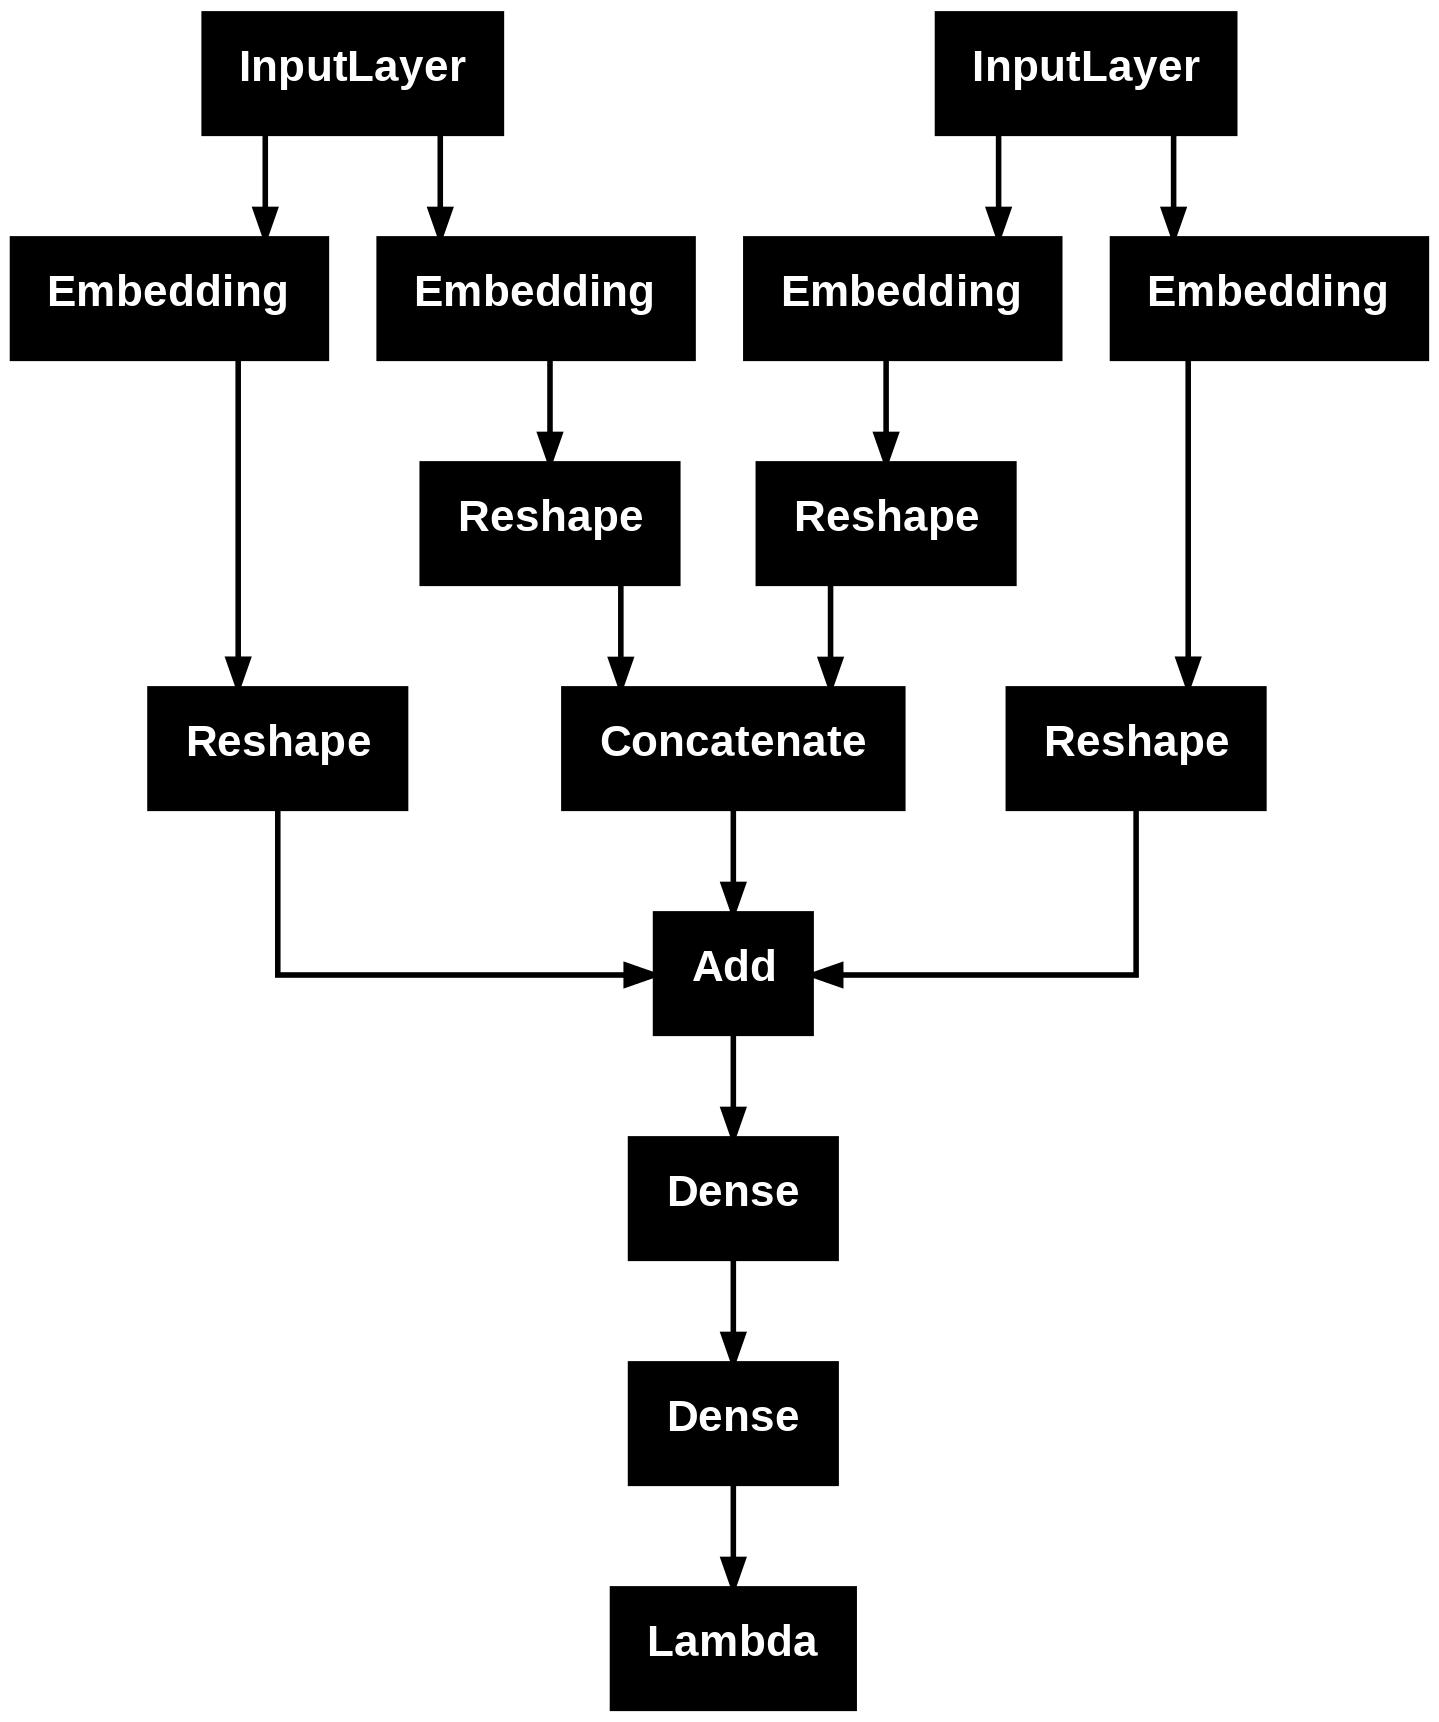

In [50]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())

# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [51]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.9867 - root_mean_squared_error: 0.9897 - val_loss: 0.7913 - val_root_mean_squared_error: 0.8892
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6849 - root_mean_squared_error: 0.8271 - val_loss: 0.7763 - val_root_mean_squared_error: 0.8805
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6258 - root_mean_squared_error: 0.7903 - val_loss: 0.7750 - val_root_mean_squared_error: 0.8795
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.5917 - root_mean_squared_error: 0.7681 - val_loss: 0.7874 - val_root_mean_squared_error: 0.8862
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.5637 - root_mean_squared_error: 0.7493 - val_loss: 0.7945 - val_root_mean_squared_error: 0.8899


## Add Dropout layer to the model

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_16 (Embedding)  │ (None, 1, 50)          │         30,500 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 1, 50)          │        486,200 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape)      │ (None, 50)             │              0 │ embedding_16[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_30 (Reshape)      │ (None, 50)             │              0 │ embedding_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 1, 1)           │            610 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_19 (Embedding)  │ (None, 1, 1)           │          9,724 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 100)            │              0 │ reshape_28[0][0],      │
│ (Concatenate)             │                        │                │ reshape_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_29 (Reshape)      │ (None, 1)              │              0 │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_31 (Reshape)      │ (None, 1)              │              0 │ embedding_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 100)            │              0 │ concatenate_3[0][0],   │
│                           │                        │                │ reshape_29[0][0],      │
│                           │                        │                │ reshape_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 10)             │          1,010 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 10)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             11 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 1)              │              0 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 528,055 (2.01 MB)

 Trainable params: 528,055 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

None


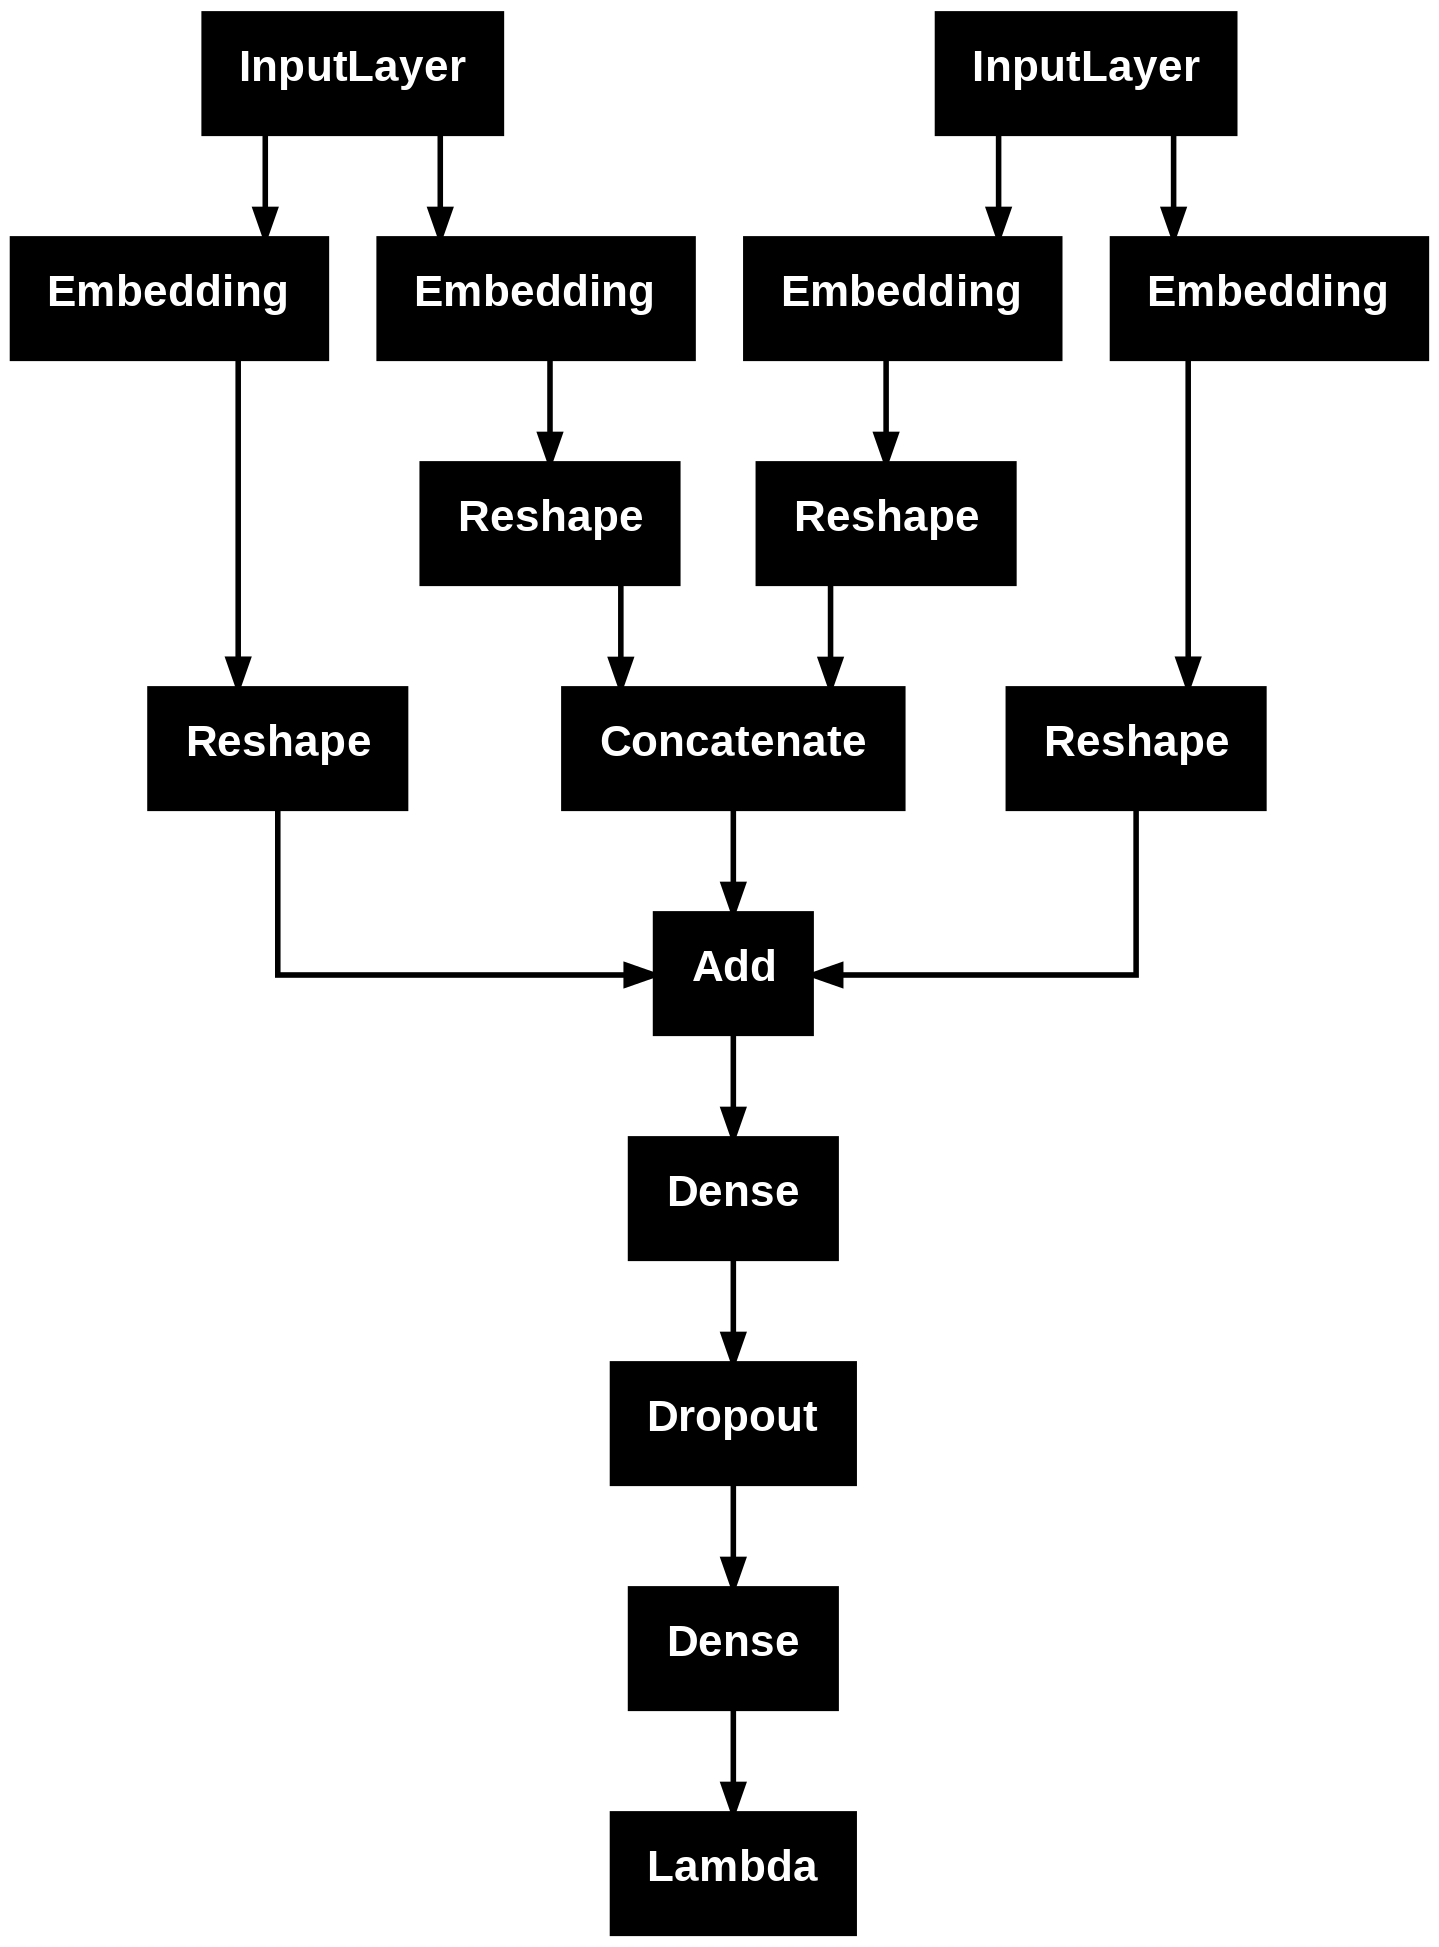

In [52]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse', metrics=[metrics.RootMeanSquaredError()], optimizer=Adam())


# Show model summary
print(model.summary())
plot_model(model, to_file='model.png')

In [53]:
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 1.0975 - root_mean_squared_error: 1.0447 - val_loss: 0.7915 - val_root_mean_squared_error: 0.8894
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.7610 - root_mean_squared_error: 0.8720 - val_loss: 0.7791 - val_root_mean_squared_error: 0.8822
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.7115 - root_mean_squared_error: 0.8429 - val_loss: 0.7754 - val_root_mean_squared_error: 0.8798
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6994 - root_mean_squared_error: 0.8355 - val_loss: 0.7822 - val_root_mean_squared_error: 0.8835
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.6813 - root_mean_squared_error: 0.8242 - val_loss: 0.7815 - val_root_mean_squared_error: 0.8829


# References
- https://developers.google.com/machine-learning/recommendation/overview
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://www.youtube.com/watch?v=gbceqO8PpBg&t=6893s
- https://www.youtube.com/watch?v=qvRL74L81lg&t=1179s
- https://github.com/jalajthanaki/Movie_recommendation_engine
- https://www.datacamp.com/community/tutorials/recommender-systems-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-763347114660:dsa-473406569915&utm_loc_interest_ms=&utm_loc_physical_ms=9073656&gclid=Cj0KCQjws_r0BRCwARIsAMxfDRiqkUn4KsOkpT75T3HPhw8A68G6b36t0kpe0XFFLUt_QGcvVPV_u1saAkfMEALw_wcB